# Chapter 14: Part-of-Speech and Sequence Annotation
## Extraction of Named Entities with Conditional Random Fields

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Modules

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from torchcrf import CRF

## Seeds
Making things reproduceable

In [3]:
random.seed(1234)
torch.manual_seed(1234)

## Constants

In [4]:
BATCH_SIZE = 32
EPOCHS = 7  # 15
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 2
DROPOUT = 0.20
EMB_LARGE = True  # GloVe 50 or 100
FREEZE_EMBS = True
LARGE_MEM = False
LR = 0.001
LOWERCASE = True

In [5]:
config = {'EPOCHS': EPOCHS,
          'LSTM_HIDDEN_DIM': LSTM_HIDDEN_DIM,
          'LSTM_LAYERS': LSTM_LAYERS,
          'DROPOUT': DROPOUT,
          'EMB_LARGE': EMB_LARGE,
          'FREEZE_EMBS': FREEZE_EMBS}

## Datasets

In [6]:
PATH = '../datasets/'

Install conlleval and download the dataset if not on your machine.

In [7]:
#!pip install conlleval
#!pip install pytorch-crf

In [8]:
import conlleval

Uncomment and run this cell to download the CoNLL 2003 dataset

In [9]:
"""!wget https://data.deepai.org/conll2003.zip
!unzip -u conll2003.zip
!mkdir ../datasets/conll2003
!mv train.txt valid.txt test.txt ../datasets/conll2003
!rm conll2003.zip"""

'!wget https://data.deepai.org/conll2003.zip\n!unzip -u conll2003.zip\n!mkdir ../datasets/conll2003\n!mv train.txt valid.txt test.txt ../datasets/conll2003\n!rm conll2003.zip'

You may need to adjust the paths to load the datasets from your machine.

In [10]:
train_file = PATH + 'conll2003/train.txt'
val_file = PATH + 'conll2003/valid.txt'
test_file = PATH + 'conll2003/test.txt'

## Reading the files

### Loading the Embeddings
We will use GloVe embeddings and load them

In [11]:
if EMB_LARGE:
    embedding_file = PATH + 'embeddings/glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = PATH + 'embeddings/glove.6B.50d.txt'
    EMBEDDING_DIM = 50

In [12]:
def read_embeddings(file: str) -> dict[str, torch.FloatTensor]:
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    with open(file) as glove:
        for line in glove:
            values = line.strip().split()
            word = values[0]
            vector = torch.FloatTensor(
                list(map(float, values[1:])))
            embeddings[word] = vector
    return embeddings

In [13]:
embeddings_dict = read_embeddings(embedding_file)

In [14]:
embeddings_dict['table']

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

You will now convert the dataset in a Python data structure. Read the functions below to load the datasets. They store the corpus in a list of sentences. Each sentence is a list of rows, where each row is a dictionary.

### Loading the Corpus

In [15]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [16]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

The CoNLL 2002 files have four columns: The wordform, `form`, its predicted part of speech, `ppos`, the predicted tag denoting the syntactic group also called the chunk tag, `pchunk`, and finally the named entity tag `ner`.

In [17]:
column_names = ['FORM', 'PPOS', 'PCHUNK', 'NER']

We load the corpus as a list of dictionaries

In [18]:
train_sentences = read_sentences(train_file)
train_dict = split_rows(train_sentences, column_names)

val_sentences = read_sentences(val_file)
val_dict = split_rows(val_sentences, column_names)

test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)

train_dict[1]

[{'FORM': 'EU', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-ORG'},
 {'FORM': 'rejects', 'PPOS': 'VBZ', 'PCHUNK': 'B-VP', 'NER': 'O'},
 {'FORM': 'German', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
 {'FORM': 'call', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
 {'FORM': 'to', 'PPOS': 'TO', 'PCHUNK': 'B-VP', 'NER': 'O'},
 {'FORM': 'boycott', 'PPOS': 'VB', 'PCHUNK': 'I-VP', 'NER': 'O'},
 {'FORM': 'British', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
 {'FORM': 'lamb', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
 {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}]

### Function to build the two-way sequences
Two vectors: $\mathbf{x}$ and $\mathbf{y}$

In [19]:
def extract_cols(sent_dict, x='FORM', y='NER'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [20]:
train_cols = [extract_cols(sent_dict)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict)
             for sent_dict in test_dict]

In [21]:
train_sent_words, train_sent_ner = zip(*train_cols)
val_sent_words, val_sent_ner = zip(*val_cols)
test_sent_words, test_sent_ner = zip(*test_cols)

In [22]:
train_sent_words[8131]

['He',
 'said',
 'Talbott',
 ',',
 'who',
 'was',
 'scheduled',
 'to',
 'return',
 'on',
 'Tuesday',
 ',',
 'would',
 'also',
 'to',
 'meet',
 'his',
 'Canadian',
 'counterpart',
 ',',
 'Gordon',
 'Smith',
 ',',
 'in',
 'Ottawa',
 'for',
 'talks',
 'that',
 'would',
 'include',
 'the',
 'situation',
 'in',
 'Haiti',
 '.']

In [23]:
if LOWERCASE:
    train_sent_words = [list(map(str.lower, sentence))
                        for sentence in train_sent_words]
    val_sent_words = [list(map(str.lower, sentence))
                      for sentence in val_sent_words]
    test_sent_words = [list(map(str.lower, sentence))
                       for sentence in test_sent_words]

In [24]:
train_sent_words[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [25]:
train_sent_ner[1]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

### Extracting the Unique Words and Parts of Speech

In [26]:
corpus_words = sorted(set([word
                           for sentence in train_sent_words
                           for word in sentence]))

In [27]:
ner_list = sorted(set([pos
                  for sentence in train_sent_ner
                  for pos in sentence]))

In [28]:
ner_list

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [29]:
NB_CLASSES = len(ner_list)
NB_CLASSES

9

### We create the dictionary
We add two words for the padding symbol and unknown words

In [30]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary = sorted(list(set(corpus_words +
                             list(embeddings_words))))
cnt_uniq = len(vocabulary) + 2
print('# unique words in the vocabulary: embeddings and corpus:',
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402597


### Function to convert the words or parts of speech to indices

In [31]:
# We start at one to make provision for the padding symbol 0
# in RNN and LSTMs and 1 for the unknown words
idx2word = dict(enumerate(vocabulary, start=2))
idx2ner = dict(enumerate(ner_list, start=1))
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11)]
NER index: [('B-LOC', 1), ('B-MISC', 2), ('B-ORG', 3), ('B-PER', 4), ('I-LOC', 5), ('I-MISC', 6), ('I-ORG', 7), ('I-PER', 8), ('O', 9)]


In [32]:
def to_index(X: list[list[str]],
             word2idx: dict[str, int],
             unk: int = 1) -> torch.LongTensor:
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to idx dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = torch.LongTensor(
            list(map(lambda x:
                     word2idx.get(x, unk), x)))
        X_idx += [x_idx]
    return X_idx

### We create the indexes

In [33]:
# We create the parallel sequences of indexes
X_train_idx = to_index(train_sent_words, word2idx)
Y_train_idx = to_index(train_sent_ner, ner2idx)

X_val_idx = to_index(val_sent_words, word2idx)
Y_val_idx = to_index(val_sent_ner, ner2idx)

X_test_idx = to_index(test_sent_words, word2idx)
Y_test_idx = to_index(test_sent_ner, ner2idx)

print('First sentences, word indices', X_train_idx[:3])
print('First sentences, NER indices', Y_train_idx[:3])

First sentences, word indices [tensor([935]), tensor([142143, 307143, 161836,  91321, 363368,  83766,  85852, 218260,    936]), tensor([284434,  79019])]
First sentences, NER indices [tensor([9]), tensor([3, 9, 2, 9, 9, 9, 2, 9, 9]), tensor([4, 8])]


### We pad the sentences
We keep the traditional order to avoid changing the dataloader

In [34]:
X_train = pad_sequence(X_train_idx, batch_first=True)
Y_train = pad_sequence(Y_train_idx, batch_first=True)

X_val = pad_sequence(X_val_idx, batch_first=True)
Y_val = pad_sequence(Y_val_idx, batch_first=True)

X_test = pad_sequence(X_test_idx, batch_first=True)
Y_test = pad_sequence(Y_test_idx, batch_first=True)

In [35]:
Y_train

tensor([[9, 0, 0,  ..., 0, 0, 0],
        [3, 9, 2,  ..., 0, 0, 0],
        [4, 8, 0,  ..., 0, 0, 0],
        ...,
        [3, 9, 3,  ..., 0, 0, 0],
        [9, 9, 0,  ..., 0, 0, 0],
        [3, 9, 3,  ..., 0, 0, 0]])

In [36]:
X_train_idx[8131:8134]

[tensor([176967, 318004, 354554,    517, 389433, 386048, 322755, 363368, 309292,
         271939, 369376,    517, 392694,  53898, 363368, 241803, 181212,  92077,
         111905,    517, 166368, 337765,    517, 190291, 274846, 153033, 354663,
         359644, 392694, 190648, 359698, 335549, 190291, 173081,    936]),
 tensor([935]),
 tensor([371668, 245894, 182065, 236839, 325743, 344614, 369376,    679, 365911,
            936])]

In [37]:
pad_sequence(X_train_idx[8131:8134], batch_first=True)

tensor([[176967, 318004, 354554,    517, 389433, 386048, 322755, 363368, 309292,
         271939, 369376,    517, 392694,  53898, 363368, 241803, 181212,  92077,
         111905,    517, 166368, 337765,    517, 190291, 274846, 153033, 354663,
         359644, 392694, 190648, 359698, 335549, 190291, 173081,    936],
        [   935,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0],
        [371668, 245894, 182065, 236839, 325743, 344614, 369376,    679, 365911,
            936,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0]])

In [38]:
pad_sequence(X_train_idx[8131:8134])

tensor([[176967,    935, 371668],
        [318004,      0, 245894],
        [354554,      0, 182065],
        [   517,      0, 236839],
        [389433,      0, 325743],
        [386048,      0, 344614],
        [322755,      0, 369376],
        [363368,      0,    679],
        [309292,      0, 365911],
        [271939,      0,    936],
        [369376,      0,      0],
        [   517,      0,      0],
        [392694,      0,      0],
        [ 53898,      0,      0],
        [363368,      0,      0],
        [241803,      0,      0],
        [181212,      0,      0],
        [ 92077,      0,      0],
        [111905,      0,      0],
        [   517,      0,      0],
        [166368,      0,      0],
        [337765,      0,      0],
        [   517,      0,      0],
        [190291,      0,      0],
        [274846,      0,      0],
        [153033,      0,      0],
        [354663,      0,      0],
        [359644,      0,      0],
        [392694,      0,      0],
        [19064

### We create an embedding matrix
0 is the padding symbol and index one is a unknown word

In [39]:
embedding_table = torch.randn(
    (len(vocabulary) + 2, EMBEDDING_DIM))/10
# embedding_table = torch.rand(
#    (len(vocabulary) + 2, EMBEDDING_DIM))/10 - 0.05  # range: -0.05, 0.05,

In [40]:
for word in vocabulary:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_table[word2idx[word]] = embeddings_dict[word]

In [41]:
embedding_table.size()

torch.Size([402597, 100])

Embedding of table

In [42]:
embedding_table[word2idx['table']]

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

Embedding of the padding symbol, idx 0, random numbers

In [43]:
embedding_table[0]

tensor([-0.0112, -0.0497,  0.0163, -0.0882,  0.0054,  0.0668, -0.0060, -0.0467,
        -0.0215,  0.0884, -0.0758, -0.0369, -0.0342, -0.1402,  0.0321, -0.1022,
         0.0799, -0.0092, -0.0705, -0.1602,  0.0289,  0.0490, -0.0385, -0.0712,
        -0.0171, -0.1459,  0.0221,  0.0246, -0.1325,  0.0697, -0.0663,  0.1216,
        -0.1495,  0.0881, -0.1179, -0.0934, -0.0568, -0.0277, -0.2183,  0.0367,
         0.0938,  0.0008, -0.0314, -0.1157,  0.1841, -0.1017,  0.1219,  0.0160,
         0.1598, -0.0047, -0.1527, -0.2014, -0.1517,  0.0388, -0.1185,  0.0690,
         0.1323,  0.1817,  0.0681,  0.0724,  0.0032, -0.1659, -0.1877,  0.0737,
         0.0926,  0.0925,  0.0183, -0.0074,  0.0315, -0.1037,  0.0210,  0.0614,
         0.0063, -0.0330, -0.1797,  0.0873,  0.0767, -0.0114, -0.0943,  0.0754,
         0.0141, -0.0694, -0.0616, -0.0730,  0.0431,  0.0286, -0.0248,  0.0204,
         0.0852, -0.1410, -0.0107, -0.0802,  0.0277,  0.2560, -0.1695,  0.0189,
         0.0739,  0.1590, -0.0195, -0.02

## Embedding Matrix

Create a numpy matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

Initialize the matrix with random values with the `torch.rand()`

The shape of your matrix is: (402597, 100) or (402597, 50)

In [44]:
embedding_table.size()

torch.Size([402597, 100])

## Network Architecture

We create your network consisting of one embedding layer, a simple recurrent neural network, either RNN or LSTM, and a linear layer. We initialize the embedding layer with `embedding_matrix` using `from_pretrained()`. We may try other configurations after. As number of RNN/LSTM units, we use 128.

In [45]:
class Model(nn.Module):

    def __init__(self, embedding_table,
                 hidden_size,
                 nbr_classes,
                 freeze_embs=True,
                 num_layers=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embeddings = nn.Embedding.from_pretrained(
            embedding_table, freeze=freeze_embs, padding_idx=0)
        self.dropout = nn.Dropout(DROPOUT)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
                            dropout=DROPOUT, batch_first=True, bidirectional=bidirectional)
        if not bidirectional:
            self.fc = nn.Linear(hidden_size, nbr_classes)
        else:
            # twice the units if bidirectional
            self.fc = nn.Linear(2*hidden_size, nbr_classes)
        self.crf = CRF(nbr_classes, batch_first=True)

    def _get_nn_logits(self, sentence):
        embeds = self.embeddings(sentence)
        # embeds = self.dropout(embeds)
        rec_out, _ = self.lstm(embeds)
        # rec_out = F.relu(rec_out)
        # rec_out = self.dropout(rec_out)
        logits = self.fc(rec_out)
        return logits

    def forward(self, sentence, tags=None, mask=None):
        nn_logits = self._get_nn_logits(sentence)
        if tags is not None:
            return -self.crf(nn_logits, tags, mask=mask)
        else:
            return self.crf.decode(nn_logits, mask=mask)

We create a model

In [46]:
model = Model(embedding_table,
              LSTM_HIDDEN_DIM,
              NB_CLASSES + 1,
              freeze_embs=FREEZE_EMBS,
              num_layers=LSTM_LAYERS,
              bidirectional=True)

In [47]:
model

Model(
  (embeddings): Embedding(402597, 100, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (crf): CRF(num_tags=10)
)

The optimizer `optimizer`

In [ ]:
optimizer = torch.optim.NAdam(model.parameters(), lr=LR)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

## Data Loaders

In [49]:
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=2048, shuffle=False)

## A Few Experiments

### Flattening the tensors

In [50]:
Y_train.size()

torch.Size([14987, 113])

In [51]:
Y_train.reshape(-1)

tensor([9, 0, 0,  ..., 0, 0, 0])

In [52]:
Y_train.reshape(-1).size()

torch.Size([1693531])

### Applying the Model

We apply the model to the whole training set. You can do it in one shot with the statements below. This can use up all your memory. Do not do it you do not have a lot of memory.

It is preferable to use smaller batches instead. This is less legible but safer. 

In [53]:
def batch_inference(model, dataloader):
    with torch.no_grad():
        y_pred = []
        for X_batch, _ in dataloader:
            mask = (X_batch != 0)
            y_pred += [model(X_batch, mask=mask)]
    return y_pred

In [54]:
X_train[:3]

tensor([[   935,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

## Training the Model

We create a dictionary to store the accuracy and the loss. We compute them in the training loop. We exclude the the padding symbols from your counts. To do this, we use a multiplicative mask with the terms Y_train > 0 or Y_val > 0. This is not critical though as we will evaluate the final results with another script. 

In [55]:
def evaluate(model,
             dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, Y_batch in dataloader:
            mask = (Y_batch != 0)
            loss += model(X_batch, Y_batch, mask=mask).item()
            Y_batch_pred = model(X_batch, mask=mask)
            t_words += mask.sum().item()
            Y_batch_pred = map(torch.tensor, Y_batch_pred)
            Y_batch_pred = pad_sequence(
                    Y_batch_pred, batch_first=True)
            sz = Y_batch_pred.size()
            accuracy += torch.mul(Y_batch_pred == Y_batch[:, :sz[1]],
                                  Y_batch[:, :sz[1]] > 0).sum().item()
        return loss/t_words, accuracy/t_words

In [56]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

We fit the model

In [57]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    t_words = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        model.train()
        mask = (Y_batch != 0)
        loss = model(X_batch, Y_batch, mask=mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            train_loss += loss.item()
            Y_batch_pred = model(X_batch, mask=mask)
            Y_batch_pred = map(torch.tensor, Y_batch_pred)
            Y_batch_pred = pad_sequence(
                Y_batch_pred, batch_first=True)
            sz = Y_batch_pred.size()
            train_accuracy += torch.mul(Y_batch_pred == Y_batch[:, :sz[1]],
                                  Y_batch[:, :sz[1]] > 0).sum().item()
            n_words = torch.sum(Y_batch > 0).item()
            t_words += n_words
    model.eval()
    with torch.no_grad():
        history['accuracy'] += [
            train_accuracy/t_words]
        history['loss'] += [train_loss/t_words]
        val_loss, val_acc = evaluate(model,
                                     val_dataloader)
        history['val_loss'] += [val_loss]
        history['val_accuracy'] += [val_acc]

100%|██████████| 469/469 [01:12<00:00,  6.49it/s]


And we visualize the training curves. We compare them with a validation set.

In [58]:
history['val_accuracy']

[0.958005351118694,
 0.9695606653999768,
 0.9727209275272403,
 0.9752995463181977,
 0.9761526232114467,
 0.9771220287719571,
 0.9764046686571795]

In [59]:
history['loss']

[0.2978155256273964,
 0.1128332432676012,
 0.08213287798253156,
 0.06290393127717914,
 0.05020501771690884,
 0.039352914493291535,
 0.03156677933623903]

In [60]:
history['val_loss']

[0.13811558862457105,
 0.09750811271278452,
 0.08535773820036523,
 0.07631723376639507,
 0.07255712118129944,
 0.0724499161918599,
 0.07781169219358908]

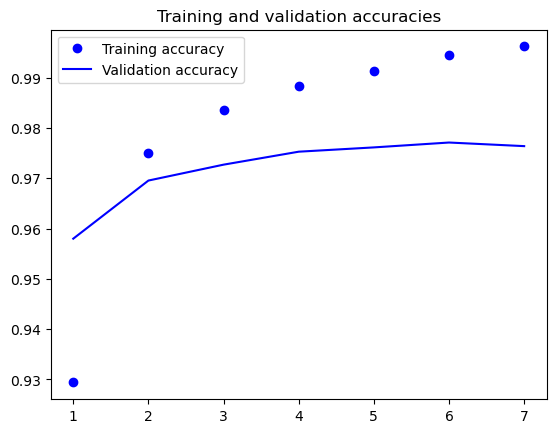

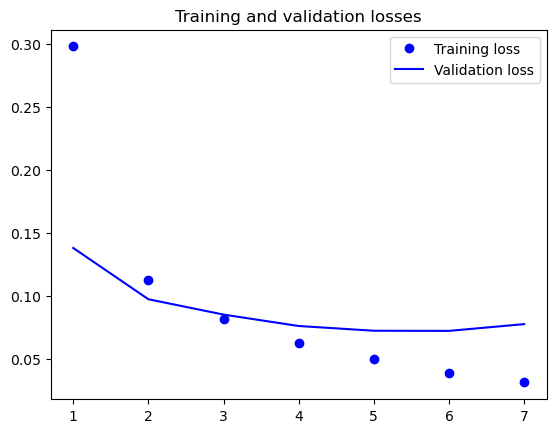

In [61]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [62]:
model.eval()

Model(
  (embeddings): Embedding(402597, 100, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (crf): CRF(num_tags=10)
)

We try the model on a test sentence

In [63]:
sentence = 'Homer wrote the Iliad .'.lower().split()

Convert the sentence words to indices

In [64]:
# The indexes or the unknown word idx
sentence_word_idxs = torch.LongTensor([word2idx[word]
                                       if word in word2idx else 1
                                       for word in sentence])

The indices. Note the 1 at the end.

In [65]:
print('Sentence', sentence)
print('Sentence word indexes', sentence_word_idxs)

Sentence ['homer', 'wrote', 'the', 'iliad', '.']
Sentence word indexes tensor([182779, 393044, 359698, 189110,    936])


Predict the tags. Call the variable `sent_tag_predictions`

In [66]:
# Write your code
sent_tag_predictions = model(sentence_word_idxs.unsqueeze(dim=0))

/opt/anaconda3/lib/python3.12/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:529.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [67]:
list(map(idx2ner.get, sent_tag_predictions[0]))

['O', 'O', 'O', 'B-MISC', 'O']

## Evaluating the Model

In [68]:
test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)
test_dict[1:2]

[[{'FORM': 'SOCCER', 'PPOS': 'NN', 'PCHUNK': 'B-NP', 'NER': 'O'},
  {'FORM': '-', 'PPOS': ':', 'PCHUNK': 'O', 'NER': 'O'},
  {'FORM': 'JAPAN', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-LOC'},
  {'FORM': 'GET', 'PPOS': 'VB', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'LUCKY', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'O'},
  {'FORM': 'WIN', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': ',', 'PPOS': ',', 'PCHUNK': 'O', 'NER': 'O'},
  {'FORM': 'CHINA', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-PER'},
  {'FORM': 'IN', 'PPOS': 'IN', 'PCHUNK': 'B-PP', 'NER': 'O'},
  {'FORM': 'SURPRISE', 'PPOS': 'DT', 'PCHUNK': 'B-NP', 'NER': 'O'},
  {'FORM': 'DEFEAT', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}]]

Predict the NER tags.

In [69]:
test_loss, test_acc = evaluate(model, test_dataloader)
test_loss, test_acc

(0.11804931651088318, 0.9650923584622637)

We now predict the whole test set and we store the results in each dictionary with the key `pner`

In [70]:
test_sentences[0]

'-DOCSTART- -X- -X- O'

In [71]:
Y_test_pred = batch_inference(model, test_dataloader)

In [72]:
Y_test_pred = [y_pred for batch in Y_test_pred for y_pred in batch]

In [73]:
Y_test

tensor([[9, 0, 0,  ..., 0, 0, 0],
        [9, 9, 1,  ..., 0, 0, 0],
        [4, 8, 0,  ..., 0, 0, 0],
        ...,
        [4, 9, 1,  ..., 0, 0, 0],
        [9, 9, 1,  ..., 0, 0, 0],
        [9, 9, 9,  ..., 0, 0, 0]])

In [74]:
for sent, y_hat in zip(test_dict, Y_test_pred):
    for word, ner_hat in zip(sent, y_hat):
        word['PNER'] = idx2ner.get(int(ner_hat))
        if word['PNER'] == None:
            print(sent)

A sentence example: `NER` is the hand annotation and `PNER` is the prediction.

In [75]:
test_dict[1]

[{'FORM': 'SOCCER', 'PPOS': 'NN', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': '-', 'PPOS': ':', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'JAPAN',
  'PPOS': 'NNP',
  'PCHUNK': 'B-NP',
  'NER': 'B-LOC',
  'PNER': 'B-LOC'},
 {'FORM': 'GET', 'PPOS': 'VB', 'PCHUNK': 'B-VP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'LUCKY', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'WIN', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': ',', 'PPOS': ',', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'CHINA',
  'PPOS': 'NNP',
  'PCHUNK': 'B-NP',
  'NER': 'B-PER',
  'PNER': 'B-LOC'},
 {'FORM': 'IN', 'PPOS': 'IN', 'PCHUNK': 'B-PP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'SURPRISE', 'PPOS': 'DT', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'DEFEAT', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'}]

In [76]:
test_dict[1]

[{'FORM': 'SOCCER', 'PPOS': 'NN', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': '-', 'PPOS': ':', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'JAPAN',
  'PPOS': 'NNP',
  'PCHUNK': 'B-NP',
  'NER': 'B-LOC',
  'PNER': 'B-LOC'},
 {'FORM': 'GET', 'PPOS': 'VB', 'PCHUNK': 'B-VP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'LUCKY', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'WIN', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': ',', 'PPOS': ',', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'CHINA',
  'PPOS': 'NNP',
  'PCHUNK': 'B-NP',
  'NER': 'B-PER',
  'PNER': 'B-LOC'},
 {'FORM': 'IN', 'PPOS': 'IN', 'PCHUNK': 'B-PP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'SURPRISE', 'PPOS': 'DT', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'DEFEAT', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'}]

In [77]:
cnt = 0
cnt_corr = 0
for s in test_dict:
    for w in s:
        if w['PNER'] == w['NER']:
            cnt_corr += 1
        cnt += 1

In [78]:
cnt_corr/cnt

0.9650923584622637

We save the test set in a file to evaluate the performance of our model.

In [79]:
column_names = ['FORM', 'PPOS', 'PCHUNK', 'NER', 'PNER']

In [80]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [81]:
outfile = 'test_model.out'

In [82]:
save(outfile, test_dict, column_names)

In [83]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.8498695691283619

In [84]:
config

{'EPOCHS': 7,
 'LSTM_HIDDEN_DIM': 128,
 'LSTM_LAYERS': 2,
 'DROPOUT': 0.2,
 'EMB_LARGE': True,
 'FREEZE_EMBS': True}

In [85]:
torch.save(model.state_dict(), 'model.pth')